# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [33]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

import matplotlib.patches as mpatches
from matplotlib.patches import Patch

from sklearn.preprocessing import MultiLabelBinarizer
from utils import *



from datetime import date
sns.set(style="darkgrid")

### Load Data

In [34]:
# read in the json files
portfolio = pd.read_json('././Data/portfolio.json', orient='records', lines=True) 
profile = pd.read_json('././Data/profile.json', orient='records', lines=True)
transcript = pd.read_json('././Data/transcript.json', orient='records', lines=True)

# Get a first look in data and clean

### Get first infos about portfolio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes
None
   reward                      channels  difficulty  duration     offer_type  \
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
9  2906b810c7d4411798c6938adc9daaa5  


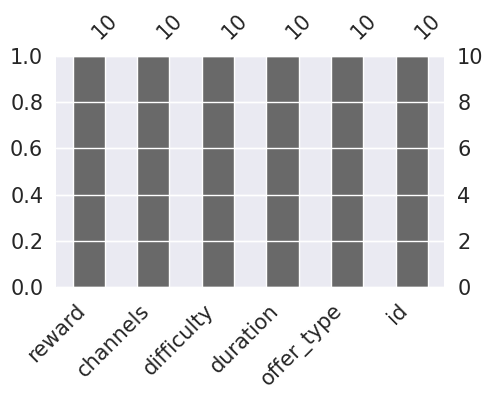

In [35]:
first_infos(df=portfolio)

* 'channels' column need to be trated
* to explore futures analysis and better visualize data, column 'offer_type' will be dummy
* No nulls

### Clean 'portfolio' data

In [36]:
mlb = MultiLabelBinarizer()

# 'channels' column dummies
channel_dummies = pd.DataFrame(mlb.fit_transform(portfolio['channels']), columns=mlb.classes_, index=portfolio.index)

# 'offer_type' column dummies
offer_type_dummies = portfolio['offer_type'].str.get_dummies()

# concatenate back to portfolio
portfolio = pd.concat([portfolio, channel_dummies, offer_type_dummies], axis=1)

# drop old columns
# portfolio = portfolio.drop(['channels', 'offer_type'], axis=1)

print(portfolio.isna().sum())
portfolio.sample(3)

reward           0
channels         0
difficulty       0
duration         0
offer_type       0
id               0
email            0
mobile           0
social           0
web              0
bogo             0
discount         0
informational    0
dtype: int64


,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0


### Get first infos about 'transcript'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None
                                  person         event  \
140026  59071e549a544cb7a89b4ab5bc88b57e   transaction   
266846  41eb66dfb4824a029f7abb81c140c267   transaction   
79602   9debe14001284c9aa55683ad27b653aa  offer viewed   

                                                   value  time  
140026                                 {'amount': 27.25}   372  
266846                                {'amount': 218.13}   588  
79602   {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}   198  


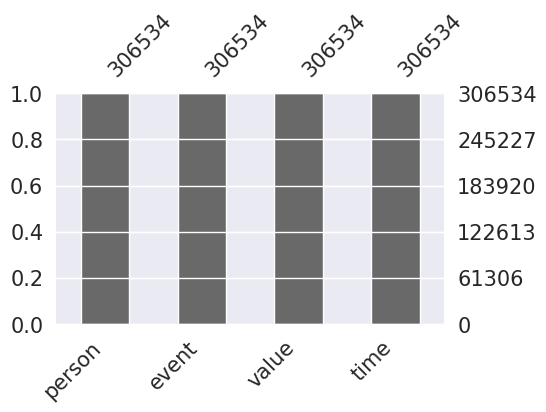

In [37]:
first_infos(df=transcript)

In [38]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

### Clean 'transcript' data

In [39]:
# 'event' column dummies
event_dummies = transcript['event'].str.get_dummies()

transcript = pd.concat([transcript, event_dummies], axis=1).rename(columns={'offer completed': 'offer_completed',\
                                                                             'offer received': 'offer_received', \
                                                                             'offer viewed': 'offer_viewed'})

# transcript = transcript.drop(['event'], axis=1)

transcript.sample(3)

,person,event,value,time,offer_completed,offer_received,offer_viewed,transaction
254748,80a081a487514d7582afd7b4addd7027,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},576,0,1,0,0
89728,bfbb2bd21f3c41488c7f80b70abffaab,transaction,{'amount': 1.18},228,0,0,0,1
46816,18f6d43ce45c41b398606753c3412f60,transaction,{'amount': 37.04},126,0,0,0,1


In [40]:
# create separate columns for amount and offer_id from value col.
transcript['offer_id'] = transcript.value.apply(create_offer_id_col)
transcript['amount'] = transcript.value.apply(create_amount_col)

# change amount column type to float
transcript['amount'] = transcript['amount'].astype('float')

# transcript = transcript.drop('value', axis=1)

# drop value column
transcript.sample(3)

,person,event,value,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,amount
11490,e8c9a3ce8bff405c89ee18f26746be2a,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
32239,ffdefcac307f4ca99ac1ebd51470f106,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,54,1,0,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
205033,320dd0b116d4427487c7d828e4b3e1be,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},504,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN


### Get first infos about 'profile'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None
     gender  age                                id  became_member_on   income
4295      M   21  df0c23fc24d14df09610544729f2aed2          20170101  41000.0
4278      F   42  3c73cc2b1d7a4d32841995ccc27886d5          20180119  65000.0
7315      M   42  b0e48cab3d794637b8f9209090989e92          20170806  68000.0


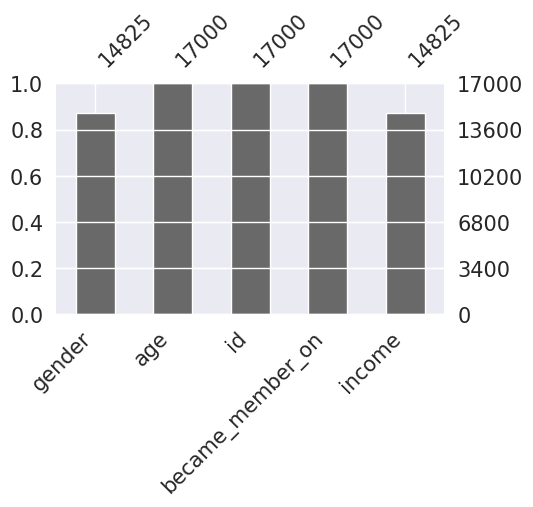

In [41]:
first_infos(df=profile)

* 'gender' and 'income' have null values

### Clean 'profile' data

In [42]:
# treat column types

#profile table
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

profile['gender'] = profile['gender'].fillna('NA')

# treat income NA's with mean value of the column 
profile['income'] = profile['income'].fillna(profile['income'].mean())

### Check distribution of profile data

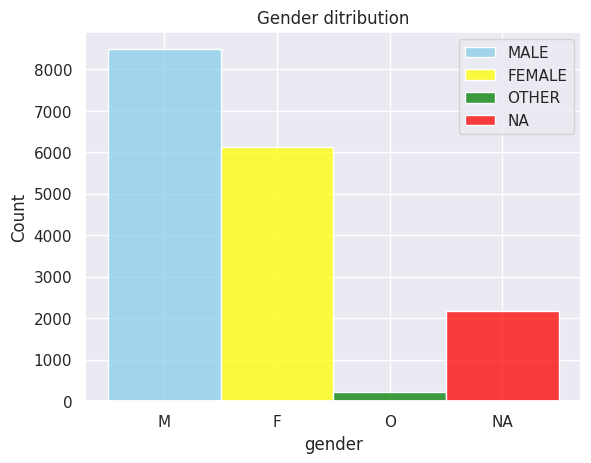

In [43]:
sns.histplot(data=profile[profile['gender'] == 'M'], x="gender", color="skyblue", label="MALE")
sns.histplot(data=profile[profile['gender'] == 'F'], x="gender", color="yellow", label="FEMALE")
sns.histplot(data=profile[profile['gender'] == 'O'], x="gender", color="green", label="OTHER")
sns.histplot(data=profile[profile['gender'] == 'NA'], x="gender", color="red", label="NA")

plt.title('Gender ditribution')
plt.legend() 
plt.show()

    index   age
0     118  2175
83    101     5
80    100    12
84     99     5
82     98     5
..    ...   ...
56     22   131
46     21   140
54     20   135
52     19   135
68     18    70

[85 rows x 2 columns]


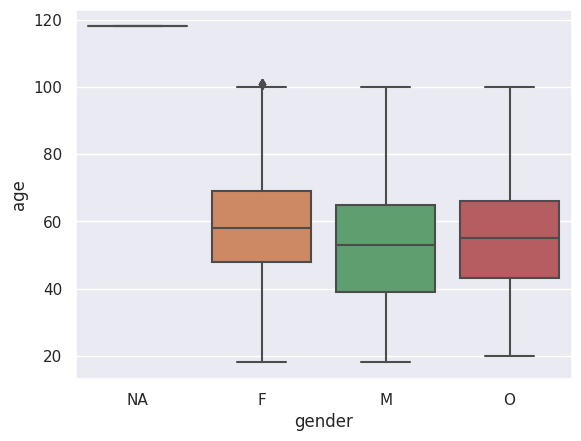

In [44]:
print(profile['age'].value_counts().reset_index().sort_values(by='index', ascending=False))
sns.boxplot(x=profile["gender"], y=profile["age"])
plt.show()

In [45]:
profile['time_membership'] = (pd.datetime.today() - pd.to_datetime(profile['became_member_on'])).astype('timedelta64[Y]').astype('int')
profile_clean = profile.drop_duplicates(['id'], keep='last')

/tmp/ipykernel_2913/2411787568.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  profile['time_membership'] = (pd.datetime.today() - pd.to_datetime(profile['became_member_on'])).astype('timedelta64[Y]').astype('int')


### merge dataframes

In [46]:
offers = transcript.copy()

offers = offers.merge(profile, left_on='person', right_on='id')
offers = offers.merge(portfolio, left_on='offer_id', right_on='id')

offers = offers.drop(['id_x', 'id_y'], axis=1)
offers = offers.set_index('offer_id').reset_index()
offers.sample(2)

,offer_id,person,event,value,time,offer_completed,offer_received,offer_viewed,transaction,amount,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
74397,0b1e1539f2cc45b7b9fa7c272da2e1d7,6b6ff823e27d4a84bd1760e772092125,offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,312,1,0,0,0,NaN,...,20,10,discount,1,0,0,1,0,1,0
144751,4d5c57ea9a6940dd891ad53e9dbe8da0,b51d59ccd5d64f9580e9d49925231cff,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,480,1,0,0,0,NaN,...,10,5,bogo,1,1,1,1,1,0,0


In [47]:
# add receipt, view and completion time columns
offers['time'] = offers['time'] + 0.5
offers['received_time'] = offers['offer_received'] * offers['time']
offers['viewed_time'] = offers['offer_viewed'] * offers['time']
offers['completed_time'] = offers['offer_completed'] * offers['time']
offers.head()

,offer_id,person,event,value,time,offer_completed,offer_received,offer_viewed,transaction,amount,...,email,mobile,social,web,bogo,discount,informational,received_time,viewed_time,completed_time
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.5,0,1,0,0,NaN,...,1,1,0,1,1,0,0,0.5,0.0,0.0
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6.5,0,0,1,0,NaN,...,1,1,0,1,1,0,0,0.0,6.5,0.0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132.5,1,0,0,0,NaN,...,1,1,0,1,1,0,0,0.0,0.0,132.5
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.5,0,1,0,0,NaN,...,1,1,0,1,1,0,0,408.5,0.0,0.0
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},420.5,0,0,1,0,NaN,...,1,1,0,1,1,0,0,0.0,420.5,0.0


## Exploratory Data Analysis

Text(0.5, 0.98, 'Histogram of all numerical variables in profile dataset')

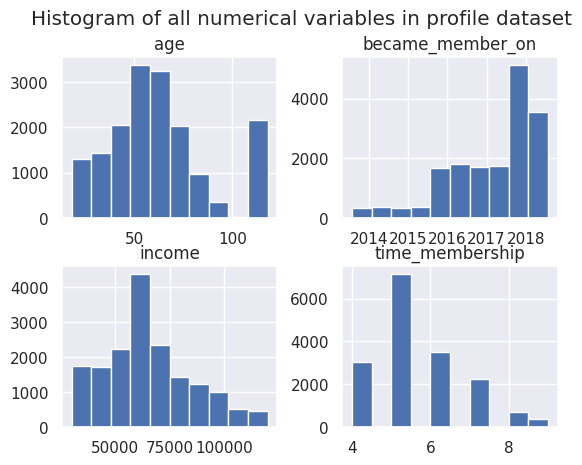

In [49]:
#Make histogram of all numerical variables
axes = profile.hist()
plt.suptitle("Histogram of all numerical variables in profile dataset")

The distributions shows the following three things about our customer profile

Most customers are in the middle to older age range
Annual income of Starbucks customers is majorly ≤$100000
Most customers take >1000 and <1250 days before they become a member

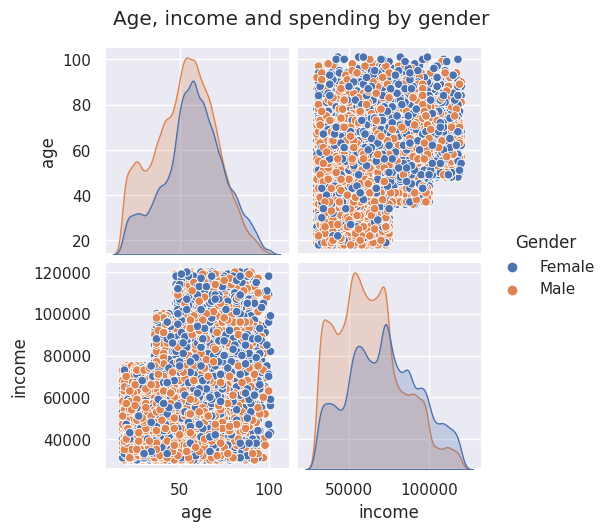

In [50]:
df = offers[['gender', 'age', 'income']].query('gender in ["F", "M"]')

df.rename(columns={'gender': 'Gender'}, inplace=True)
df['Gender'] = df['Gender'].map({'M': 'Male', 'F': 'Female'})

g = sns.pairplot(df, hue='Gender')
g.fig.suptitle("Age, income and spending by gender", y=1.05);

<Axes: xlabel='offer_type', ylabel='count'>

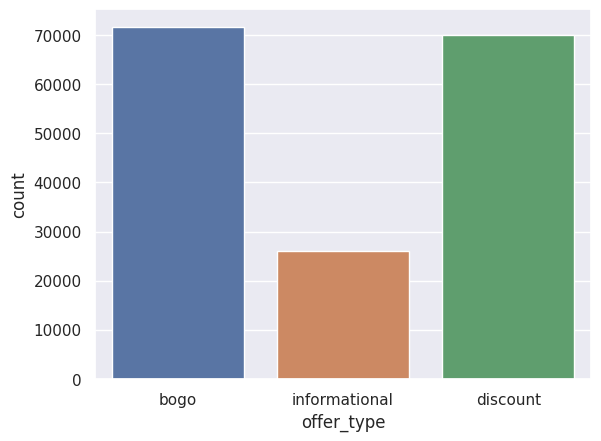

In [51]:
# checking distribution of events in the dataframe

sns.countplot(data=offers, x='offer_type')

In [52]:
offers.groupby(['offer_type', 'event']).size()

offer_type     event          
bogo           offer completed    15669
               offer received     30499
               offer viewed       25449
discount       offer completed    17910
               offer received     30543
               offer viewed       21445
informational  offer received     15235
               offer viewed       10831
dtype: int64

## Data modeling

In order to build a recomendation engine, we can use FunkSVD algorithm. The dataset needs to be in user-item matrix format for that purposes. Following functions will help further transform the datasets

In [54]:
#create User item matrix of customers and offers they accept
all_df = 'create_user_item_matrix(transcript, 'user_item_matrix.p')

In [60]:
all_df = pd.read_pickle('././RecommendationModel-files/user_item_matrix.p')
train_matrix = pd.read_pickle('././RecommendationModel-files/train_df.p')
test_matrix = pd.read_pickle('././RecommendationModel-files/test_df.p')

In [89]:
training_df,test_df,train_matrix, test_matrix= user_item_train_test_split(transcript)

In [69]:
# Fit FunkSVD with the specified hyper parameters to the training data
np_train=np.matrix(train_matrix)

user_mat_20, offer_mat_20 = FunkSVD(np_train, latent_features=20, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.076958
2 		 0.030213
3 		 0.028780
4 		 0.028409
5 		 0.028208
6 		 0.028046
7 		 0.027895
8 		 0.027748
9 		 0.027603
10 		 0.027459
11 		 0.027316
12 		 0.027174
13 		 0.027033
14 		 0.026892
15 		 0.026753
16 		 0.026615
17 		 0.026477
18 		 0.026340
19 		 0.026205
20 		 0.026070
21 		 0.025936
22 		 0.025802
23 		 0.025670
24 		 0.025538
25 		 0.025407
26 		 0.025278
27 		 0.025148
28 		 0.025020
29 		 0.024892
30 		 0.024766
31 		 0.024640
32 		 0.024514
33 		 0.024390
34 		 0.024266
35 		 0.024143
36 		 0.024021
37 		 0.023900
38 		 0.023779
39 		 0.023659
40 		 0.023540
41 		 0.023421
42 		 0.023303
43 		 0.023186
44 		 0.023070
45 		 0.022954
46 		 0.022839
47 		 0.022724
48 		 0.022611
49 		 0.022498
50 		 0.022385
51 		 0.022273
52 		 0.022162
53 		 0.022052
54 		 0.021942
55 		 0.021833
56 		 0.021724
57 		 0.021616
58 		 0.021509
59 		 0.021402
60 		 0.021296
61 		 0.021191
62 		 0.021086
63 		 0.020982
64 		 0

In [63]:
# Test for the best number of latent feature. (with latent features 10)
user_mat_15, offer_mat_15 = FunkSVD(np_train, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.058970
2 		 0.031408
3 		 0.030368
4 		 0.030035
5 		 0.029796
6 		 0.029578
7 		 0.029367
8 		 0.029159
9 		 0.028954
10 		 0.028751
11 		 0.028550
12 		 0.028351
13 		 0.028154
14 		 0.027958
15 		 0.027764
16 		 0.027572
17 		 0.027381
18 		 0.027193
19 		 0.027005
20 		 0.026820
21 		 0.026636
22 		 0.026454
23 		 0.026274
24 		 0.026095
25 		 0.025917
26 		 0.025742
27 		 0.025567
28 		 0.025395
29 		 0.025224
30 		 0.025054
31 		 0.024886
32 		 0.024719
33 		 0.024554
34 		 0.024390
35 		 0.024228
36 		 0.024067
37 		 0.023907
38 		 0.023749
39 		 0.023592
40 		 0.023436
41 		 0.023282
42 		 0.023129
43 		 0.022978
44 		 0.022828
45 		 0.022679
46 		 0.022531
47 		 0.022385
48 		 0.022240
49 		 0.022096
50 		 0.021953
51 		 0.021812
52 		 0.021671
53 		 0.021532
54 		 0.021394
55 		 0.021257
56 		 0.021122
57 		 0.020987
58 		 0.020854
59 		 0.020721
60 		 0.020590
61 		 0.020460
62 		 0.020331
63 		 0.020203
64 		 0

In [64]:
# Test for the best number of latent feature. (with latent features 10)
user_mat_10, offer_mat_10 = FunkSVD(np_train, latent_features=10, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.053938
2 		 0.034248
3 		 0.033420
4 		 0.032991
5 		 0.032624
6 		 0.032274
7 		 0.031931
8 		 0.031594
9 		 0.031262
10 		 0.030935
11 		 0.030612
12 		 0.030294
13 		 0.029980
14 		 0.029671
15 		 0.029365
16 		 0.029064
17 		 0.028767
18 		 0.028475
19 		 0.028186
20 		 0.027901
21 		 0.027620
22 		 0.027343
23 		 0.027070
24 		 0.026800
25 		 0.026534
26 		 0.026272
27 		 0.026014
28 		 0.025759
29 		 0.025507
30 		 0.025259
31 		 0.025014
32 		 0.024772
33 		 0.024534
34 		 0.024299
35 		 0.024067
36 		 0.023838
37 		 0.023613
38 		 0.023390
39 		 0.023170
40 		 0.022954
41 		 0.022740
42 		 0.022529
43 		 0.022321
44 		 0.022115
45 		 0.021913
46 		 0.021713
47 		 0.021516
48 		 0.021321
49 		 0.021129
50 		 0.020939
51 		 0.020752
52 		 0.020567
53 		 0.020385
54 		 0.020205
55 		 0.020028
56 		 0.019853
57 		 0.019680
58 		 0.019509
59 		 0.019341
60 		 0.019175
61 		 0.019010
62 		 0.018848
63 		 0.018689
64 		 0

In [65]:
# Test for the best number of latent feature. (with latent features 5)
user_mat_5, offer_mat_5 = FunkSVD(np_train, latent_features=5, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.050648
2 		 0.045307
3 		 0.044108
4 		 0.043130
5 		 0.042198
6 		 0.041292
7 		 0.040411
8 		 0.039553
9 		 0.038719
10 		 0.037906
11 		 0.037116
12 		 0.036346
13 		 0.035597
14 		 0.034868
15 		 0.034158
16 		 0.033467
17 		 0.032795
18 		 0.032141
19 		 0.031503
20 		 0.030883
21 		 0.030280
22 		 0.029692
23 		 0.029120
24 		 0.028562
25 		 0.028020
26 		 0.027492
27 		 0.026978
28 		 0.026477
29 		 0.025989
30 		 0.025514
31 		 0.025052
32 		 0.024601
33 		 0.024162
34 		 0.023735
35 		 0.023319
36 		 0.022913
37 		 0.022518
38 		 0.022132
39 		 0.021757
40 		 0.021391
41 		 0.021035
42 		 0.020688
43 		 0.020349
44 		 0.020019
45 		 0.019697
46 		 0.019384
47 		 0.019078
48 		 0.018780
49 		 0.018489
50 		 0.018206
51 		 0.017929
52 		 0.017660
53 		 0.017397
54 		 0.017140
55 		 0.016890
56 		 0.016645
57 		 0.016407
58 		 0.016175
59 		 0.015948
60 		 0.015726
61 		 0.015510
62 		 0.015299
63 		 0.015093
64 		 0

*Check performance of the FUNKSVD models with the various number of latent features against the test dataset*

In [72]:
# Evaluation for latent features of 20
validation_score(test_matrix, user_mat_20, offer_mat_20)

Validation score:  0.9096931845478357


In [73]:
# Evaluation for latent features of 15
validation_score(test_matrix, user_mat_15, offer_mat_15)

Validation score:  0.8947876014654809


In [74]:
# Evaluation for latent features of 10
validation_score(test_matrix, user_mat_10, offer_mat_10)

Validation score:  0.8879592878524719


In [75]:
# Evaluation for latent features of 5
validation_score(test_matrix, user_mat_5, offer_mat_5)

Validation score:  0.9101348269561645


Based on the validation scores the model using latent featues of 5 seems to be performing the best.

## Make Recomendations

Since our training dataset only consists of some users, we need to have a recommendation engine that can also handle a new user. Below functions will help make default offer recommendations to a new Customer by recommending offer which generated the maximum reactions from existing Customers.

In [80]:
def offer_max_reactions(user_item_matrix):
    # Find out which offer is accepted the most number of times

    offer_count = []
    for offer_id in user_item_matrix.columns:
        offer_count.append([offer_id, len(transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))])])

    offer_reactions = pd.DataFrame(offer_count, columns=['offer_id', 'Total_reactions'])
    offer_reactions['Total_reactions'] = pd.to_numeric(offer_reactions['Total_reactions'])
    offer_reactions.sort_values(by='Total_reactions', ascending=False, inplace=True)
    
    return offer_reactions

In [81]:
offer_reactions=offer_max_reactions(all_df)
offer_reactions=offer_reactions.merge(portfolio[['id','offer_type']], left_on='offer_id',right_on='id', how='left').head()

In [82]:
offer_reactions.sample(5)

,offer_id,Total_reactions,id,offer_type
1,2298d6c36e964ae4a3e7e9706d1fb8c2,83622,2298d6c36e964ae4a3e7e9706d1fb8c2,discount
0,fafdcd668e3743c1bb461111dcafc2a4,89605,fafdcd668e3743c1bb461111dcafc2a4,discount
3,4d5c57ea9a6940dd891ad53e9dbe8da0,52353,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo
2,f19421c1d4aa40978ebb69ca19b0e20d,67738,f19421c1d4aa40978ebb69ca19b0e20d,bogo
4,ae264e3637204a6fb9bb56bc8210ddfd,51226,ae264e3637204a6fb9bb56bc8210ddfd,bogo


Text(0, 0.5, 'Total Reactions')

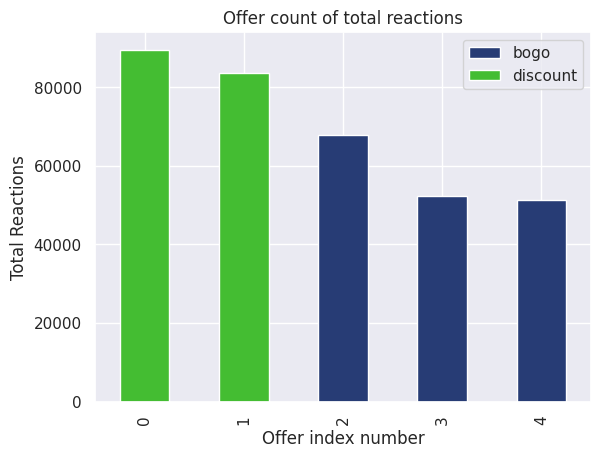

In [84]:
colours = {"bogo": "#273c75", "discount": "#44bd32"}
offer_reactions['Total_reactions'].plot(
        kind="bar", color=offer_reactions['offer_type'].replace(colours)
).legend(
    [
        Patch(facecolor=colours['bogo']),
        Patch(facecolor=colours['discount'])
    ], ["bogo", "discount"]
)
plt.title('Offer count of total reactions')
plt.xlabel('Offer index number')
plt.ylabel('Total Reactions')

From the above chart it is clear that discount is the best performing offer in the dataset

In [87]:
#Make best reccomendation for existing user
make_recommendations('0610b486422d4921ae7d2bf64640c50b', user_mat_5, offer_mat_5)

offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  1.39


In [88]:
# Make best reccomendation for new user
make_recommendations('new_user', user_mat_5, offer_mat_5)

Since this user is new, we are reccomending the best performing offer
                           offer_id  Total_reactions  \
0  fafdcd668e3743c1bb461111dcafc2a4            89605   

                                 id offer_type  
0  fafdcd668e3743c1bb461111dcafc2a4   discount  


## Next steps and improvements
In order to improve the above recommendation engine, I would suggest the following approaches.

The default recommendation for new users can be improved by accounting for demographic information such as gender, age, etc assuming such information is available to us


## Credits and references
Starbucks and Udacity for dataset
Udacity implementing 'Matrix factorization for Recommendations' lesson for function implementations such as FunkSVD, User item matrix creations, prediction and validation